# Stage 1. Corpus Creation




## 1. Assembling metadata

To retrieve metadata on the winning books, I used an online tool to scrape tables from the Wikipedia pages of the prizes and turn them in csv files. Then, I assembled them together using the following code in PyCharm. I made sure there were no redundant information – since often times some of the nominees of the Nebula and the Hugo overlap – and I created a CSV files with all the books’ metadata. The corpus now counted 726 entries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def finalmeta_extraction(file_path):

    with open(file_path, 'r', encoding='utf-8') as csvfile:  # csvfile it's a variable
        reader = csv.DictReader(csvfile)  # DictReader it's a module needed for reading .csv files
        finalmeta_dict = dict() # our data structure: in  the values assigned to keys are dictionaries
        for row in reader:  # iteration over "rows" in .csv file
            if row["date"] > "1899" and "scifi" in row["tags"]:
                dictid = row["title"].lower()
                finalmeta_dict[dictid] = dict()
                finalmeta_dict[dictid]["htid"] = row["docid"]
                finalmeta_dict[dictid]["author"] = row["author"]
                finalmeta_dict[dictid]["date"] = row["date"]
                finalmeta_dict[dictid]["title"] = row["title"]

        return finalmeta_dict


def hugo_extraction(file_path):

    with open(file_path, 'r', encoding='utf-8') as csvfile:  # csvfile it's a variable
        reader = csv.DictReader(csvfile)  # DictReader it's a module needed for reading .csv files
        hugo_dict = dict()  # our data structure: in  the values assigned to keys are dictionaries
        for row in reader:  # iteration over "rows" in .csv file
            year = str(int(row["Year"]) - 1)
            title = title_polisher(row["Novel"])
            dictid = title.lower()
            name = name_polisher(row["Author(s)"])
            if dictid in hugo_dict.keys():
                hugo_dict[dictid]["author"] = hugo_dict[dictid]["author"] + ", " + name
            else:
                hugo_dict[dictid] = dict()
                hugo_dict[dictid]["htid"] = " "
                hugo_dict[dictid]["author"] = name
                hugo_dict[dictid]["date"] = year
                hugo_dict[dictid]["title"] = row["Novel"]

        return hugo_dict


def nebula_extraction(file_path):

    with open(file_path, 'r', encoding='utf-8') as csvfile:  # csvfile it's a variable
        reader = csv.DictReader(csvfile)  # DictReader it's a module needed for reading .csv files
        nebula_dict = dict()  # our data structure: in  the values assigned to keys are dictionaries
        for row in reader:  # iteration over "rows" in .csv file
            year = str(int(row["Year"]) - 1)
            name = name_polisher(row["Author"])
            dictid = row["Novel"].lower()
            if dictid in nebula_dict.keys():
                nebula_dict[dictid]["author"] = nebula_dict[dictid]["author"] + ", " + name
            else:
                nebula_dict[dictid] = dict()
                nebula_dict[dictid]["htid"] = " "
                nebula_dict[dictid]["author"] = name
                nebula_dict[dictid]["date"] = year
                nebula_dict[dictid]["title"] = row["Novel"]

        return nebula_dict


def name_polisher(name):
    name_wo_stars = name.replace("*", "")
    name_split = name_wo_stars.split(" ")
    if name_split[len(name_split)-2].lower() == "van" or name_split[len(name_split)-2].lower() == "le":
        last_name = name_split[len(name_split) - 2] + " " + name_split[len(name_split) - 1]
        name_split.insert(0, last_name)
        name_split.pop()
        name_split.pop()
    else:
        last_name = name_split[len(name_split)-1] + ","
        name_split.insert(0, last_name)
        name_split.pop()

    polished_name = " ".join(name_split)

    return polished_name

def title_polisher(title):
    title_split = title.split(" (")
    new_title = title_split[0]

    return new_title

In [3]:
def metadata_dict_creation(path1, path2, path3, path4):
    metadata_dict1 = dict()
    metadata_dict1.update(nebula_extraction(path3))
    metadata_dict1.update(hugo_extraction(path1))
    metadata_dict1.update(hugo_extraction(path2))
    metadata_dict1.update(finalmeta_extraction(path4))

    metadata_dict2 = dict()

    for value in metadata_dict1.values():
        dictid = value["date"] + "_" + value["title"]
        metadata_dict2[dictid] = dict()
        metadata_dict2[dictid].update(value)

    sorted_metadata_dict = dict(sorted(metadata_dict2.items()))

    return sorted_metadata_dict


def metadata_csv_creation(dictionary):

    with open('metadata.csv', 'w', newline="") as csvfile:
        fieldnames = ["htid", "author", "date", "title"]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for i in dictionary.values():
            writer.writerow(i)


dictio = metadata_dict_creation("hugo.csv", "retrohugo.csv", "nebula.csv", "finalmeta.csv")

#print(metadata_csv_creation(dictio))

FileNotFoundError: ignored

In [0]:
data = pd.read_csv("metadata.csv")
#data.drop(columns="Unnamed: 0", inplace=True)
data.set_index("htid", inplace=True)

data.head()

## 2. HTIDs retrieval

Matthew Wilkens wrote an algorithm to retrieve the books' identifiers from the HathiTrust collection querying the available metadata.

Then, 5% of the obtained identifiers were manually checked to evaluate whether the returned HTIDs were correct and whether a considerable amount of identifiers were missed.

Since very few title were incorrect or had been missed, we proceeded to form the corpus with the obtained 330 titles.

## 3. Metadata with htids

In [4]:
data = pd.read_csv("metadata_with_htids.csv", encoding="utf-8")
data.drop(columns="Unnamed: 0", inplace=True)
data.head()

,htid,title,author,title_htrc,date,pub_date_htrc
0,nyp.33433076024060,The secret of the crater,"Osborne, Duffield,",NaN,1900,NaN
1,inu.30000042750632,A woman of Mars,"Ling, M. A. Moore Bentley",NaN,1901,NaN
2,njp.32101021206436,The first men in the moon,"Wells, H. G.",NaN,1901,NaN
3,nyp.33433074954656,Welsh rarebit tales,"Owen, Harle Oren.",NaN,1902,NaN
4,mdp.39015059642994,Strange case of Dr. Jekyl,"Stevenson, Robert Louis,",NaN,1903,NaN


Text(0.5, 1.0, 'Corpus without htids')

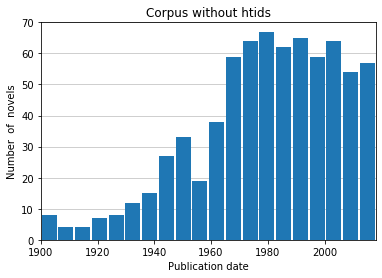

In [0]:
# Histogram plot for books with/without HTIDs

plt.hist(data.date, bins=20, rwidth=0.90, zorder=3);
plt.xlim(data.date.min(), data.date.max())
plt.ylim(0,70);
plt.grid(axis="y", alpha=0.75)
plt.xlabel("Publication date")
plt.ylabel("Number  of  novels")
plt.title("Corpus without htids")
#plt.savefig("metadata.png", dpi=300)

In [0]:
#Code by Matthew Wilkens
def validate_htid(s, none_as_good=True):
    '''
    Check HTID string for validity. 
    Not rigorous; just contains a period and
    is more than five characters long.
    Text string 'None' in HTID field indicates 
    human determination that vol not in Hathi. This is valid.
    Returns true if HTID is valid, else False.
    '''
    if s == 'None':
        if none_as_good:
            return True
        else:
            return False
    elif s is not None and len(str(s)) > 5 and '.' in str(s):
        return True
    else:
        return False

In [0]:
# Code by Matthew Wilkens
# Select rows with good HTIDS
d = data.loc[data.htid.apply(lambda x: validate_htid(x, none_as_good=False))]

Text(0.5, 1.0, 'Corpus with htids')

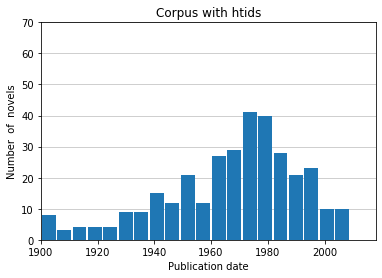

In [9]:
# Histogram plot with only books with good HTIDs

plt.hist(d.date, bins=20, rwidth=0.90, zorder=3)
plt.xlim(data.date.min(), data.date.max())
plt.ylim(0,70);
plt.grid(axis="y", alpha=0.75)
plt.xlabel("Publication date")
plt.ylabel("Number  of  novels")
plt.title("Corpus with htids")
#plt.savefig("metadata_htids.png", dpi=300)

In [0]:
#Group books with good HTIDs by decade
data.set_index("htid", inplace=True)
data.rename(columns={"title":"number of novels", "date":"decade"}, inplace=True)
df = data.groupby((data.decade//10)*10).count().drop(columns=['author', 'title_htrc', 'decade', 'pub_date_htrc'])

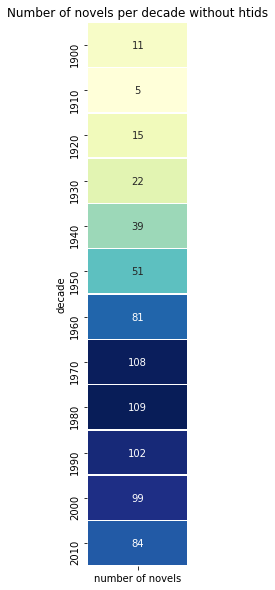

In [0]:
# Heatmap of the number of books with good htids per decade

fig, ax = plt.subplots(figsize=(7,10))
sns.heatmap(df, annot=True, cmap="YlGnBu", fmt="d", linewidths=.5, cbar=False, ax=ax)
ax.set_title("Number of novels per decade with htids")
fig.subplots_adjust(left=0.5, right=0.7)
#fig.savefig("metadata_decade.png", dpi=300)

In [0]:
data.to_csv("metadata_good_htids.csv")